Engagement data:
   User_A User_B  Likes  Comments  Shares  Engagement_Score
0     U1     U2      5         1       0                 7
1     U1     U3      2         0       0                 2
2     U2     U3      3         2       1                10
3     U3     U4      4         1       0                 6
4     U3     U1      1         1       0                 3
5     U4     U3      3         0       0                 3

Graph nodes: ['U1', 'U2', 'U3', 'U4']
Graph edges with weights: [('U1', 'U2', {'weight': 7}), ('U1', 'U3', {'weight': 3}), ('U2', 'U3', {'weight': 10}), ('U3', 'U4', {'weight': 3})]


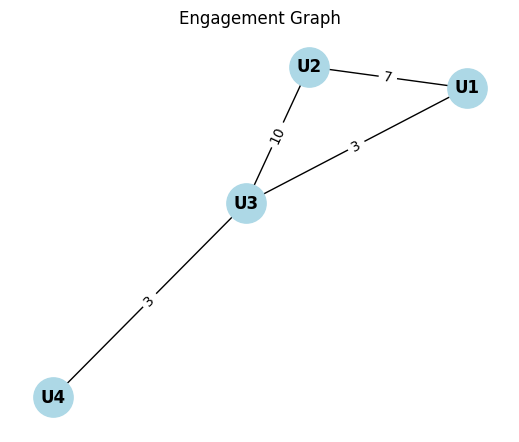


Adjacency Matrix:
 [[ 0.  7.  3.  0.]
 [ 7.  0. 10.  0.]
 [ 3. 10.  0.  3.]
 [ 0.  0.  3.  0.]]

Degree Matrix:
 [[10.  0.  0.  0.]
 [ 0. 17.  0.  0.]
 [ 0.  0. 16.  0.]
 [ 0.  0.  0.  3.]]

Graph Laplacian (L):
 [[ 10.  -7.  -3.   0.]
 [ -7.  17. -10.   0.]
 [ -3. -10.  16.  -3.]
 [  0.   0.  -3.   3.]]

Eigenvalues (sorted): [-3.98235149e-15  3.49507036e+00  1.52337456e+01  2.72711840e+01]

Spectral embedding (2D coordinates):
 [[-0.39944606 -0.74380923]
 [-0.31101767  0.30955475]
 [-0.14041494  0.57534171]
 [ 0.85087866 -0.14108722]]

Cluster assignments:
User U1 -> Cluster 0
User U2 -> Cluster 0
User U3 -> Cluster 0
User U4 -> Cluster 1


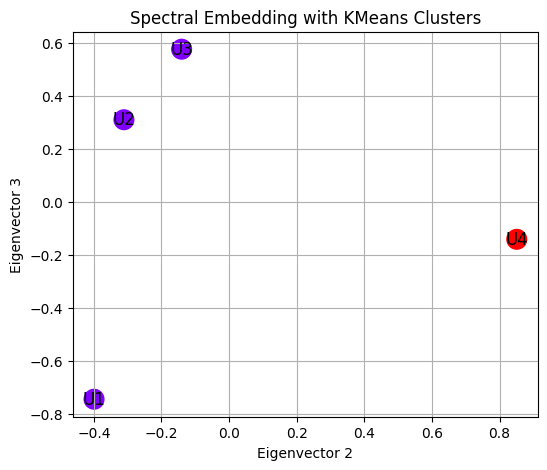


Influencer Ranking Table (by Eigenvector Centrality):
   User  Degree_Centrality  Betweenness  Eigenvector_Centrality  Cluster
1   U2           0.666667     0.000000                0.652584        0
2   U3           1.000000     0.666667                0.592627        0
0   U1           0.666667     0.333333                0.454646        0
3   U4           0.333333     0.000000                0.127373        1

Silhouette Score: 0.22636071457309392
Modularity: -0.008506616257088942


In [1]:

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from networkx.algorithms.community import modularity

# ----------------------------
# STEP 1: CREATE OR LOAD DATA
# ----------------------------

# Example simulated Instagram engagement data
data = pd.DataFrame({
    "User_A": ["U1", "U1", "U2", "U3", "U3", "U4"],
    "User_B": ["U2", "U3", "U3", "U4", "U1", "U3"],
    "Likes": [5, 2, 3, 4, 1, 3],
    "Comments": [1, 0, 2, 1, 1, 0],
    "Shares": [0, 0, 1, 0, 0, 0]
})

# Weighted engagement score (comments weighted more)
data["Engagement_Score"] = data["Likes"] + 2*data["Comments"] + 3*data["Shares"]
print("Engagement data:\n", data)

# ----------------------------
# STEP 2: BUILD INTERACTION GRAPH
# ----------------------------
G = nx.Graph()
for _, row in data.iterrows():
    G.add_edge(row["User_A"], row["User_B"], weight=row["Engagement_Score"])

print("\nGraph nodes:", G.nodes())
print("Graph edges with weights:", G.edges(data=True))

# Quick visualization
plt.figure(figsize=(5,4))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Engagement Graph")
plt.show()

# ----------------------------
# STEP 3: BUILD MATRICES (Adjacency, Degree, Laplacian)
# ----------------------------
A = nx.to_numpy_array(G, weight="weight")
nodes = list(G.nodes())
D = np.diag(A.sum(axis=1))
L = D - A

print("\nAdjacency Matrix:\n", A)
print("\nDegree Matrix:\n", D)
print("\nGraph Laplacian (L):\n", L)

# ----------------------------
# STEP 4: SPECTRAL EMBEDDING
# ----------------------------
eigvals, eigvecs = np.linalg.eigh(L)
idx = np.argsort(eigvals)
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

print("\nEigenvalues (sorted):", eigvals)

# Choose embedding dimension k=2 (skip the first eigenvector associated with eigenvalue 0)
k = 2
embedding = eigvecs[:, 1:k+1]
print("\nSpectral embedding (2D coordinates):\n", embedding)

# ----------------------------
# STEP 5: KMEANS CLUSTERING
# ----------------------------
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(embedding)
print("\nCluster assignments:")
for user, cluster in zip(nodes, labels):
    print(f"User {user} -> Cluster {cluster}")

# Plot embedding with clusters
plt.figure(figsize=(6,5))
plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='rainbow', s=200)
for i, user in enumerate(nodes):
    plt.text(embedding[i,0], embedding[i,1], user, fontsize=12, ha='center', va='center', color='black')
plt.title("Spectral Embedding with KMeans Clusters")
plt.xlabel("Eigenvector 2")
plt.ylabel("Eigenvector 3")
plt.grid()
plt.show()

# ----------------------------
# STEP 6: INFLUENCER RANKING
# ----------------------------
deg_centrality = nx.degree_centrality(G)
bet_centrality = nx.betweenness_centrality(G, weight="weight")
eig_centrality = nx.eigenvector_centrality_numpy(G, weight="weight")

centrality_df = pd.DataFrame({
    "User": nodes,
    "Degree_Centrality": [deg_centrality[u] for u in nodes],
    "Betweenness": [bet_centrality[u] for u in nodes],
    "Eigenvector_Centrality": [eig_centrality[u] for u in nodes],
    "Cluster": labels
}).sort_values(by="Eigenvector_Centrality", ascending=False)

print("\nInfluencer Ranking Table (by Eigenvector Centrality):\n", centrality_df)

# ----------------------------
# STEP 7: EVALUATION METRICS
# ----------------------------
sil_score = silhouette_score(embedding, labels)
print("\nSilhouette Score:", sil_score)

communities = [set(np.array(nodes)[labels == c]) for c in set(labels)]
mod_score = modularity(G, communities)
print("Modularity:", mod_score)
